In [1]:
import netCDF4 as nc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gsw
import cmocean as cm

import warnings
warnings.filterwarnings('ignore')


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
def find_nearest(array, value):
    
    import numpy as np
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def find_DIC_corresp_to_pco2(tsal, ttemp, tpco2, tta, pres_atm, depth_this):
    
    import numpy as np
    import mocsy
    
    steps = 10000
    tsal_r = np.zeros([steps])
    tsal_r[:] = tsal
    ttemp_r = np.zeros([steps])
    ttemp_r[:] = ttemp
    tta_r = np.zeros([steps])
    tta_r[:] = tta * 1e-3
    tpres_r = np.zeros([steps])
    tpres_r[:] = pres_atm
    depth_r = np.zeros([steps])
    depth_r[:] = depth_this
    tzero = np.zeros([steps])

    end_d = 2400
    start_d = 600
    intvl = (end_d - start_d)/steps
    tdic_r = np.arange(start_d,end_d-0.1,intvl) * 1e-3
    
    response_tup = mocsy.mvars(temp=ttemp_r, sal=tsal_r, alk=tta_r, dic=tdic_r, 
                       sil=tzero, phos=tzero, patm=tpres_r, depth=depth_r, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
    
    diffmat = pco2 - tpco2
    idx, ans = find_nearest( diffmat,0 )
    
    if ans> 2:
        print('Danger, pco2 found >2 uatm from pco2 given')
#     print(idx)
#     print('difference between real pco2 and pco2 from calc. dic: ',ans)
#     print('DIC found this way:', tdic_r[idx]*1e3)
    fin_dic = tdic_r[idx]*1e3
    
    return fin_dic

def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    import sys
    sys.path.append('/data/tjarniko/mocsy')
    import mocsy
    import numpy as np
    import gsw
    
    size_box = np.shape(tdic)
    print(size_box)

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH
    OmAr = OmegaA
    pco2r = pco2
    
    return pHr, OmAr, pco2r

def co2_from_year(year):
    import pandas as pd
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    co2_rec = pd.read_csv('lawdome_maunaloa.csv') 
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #('year > 2018, using value for 2018')
        
    if whole_year <= 1832:
        whole_year = 1832
        #('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2


def calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind):
    import numpy as np
    import netCDF4 as nc
    import gsw
    
    """
    the only thing that has been changed is that we're doing this for a single depth profile
    - Opens a LiveOcean netcdf file
    - Calculates potential density
    - Uses a derived relationship between potential density (sigma0) and 
    cfc-freon11 estimated watermass age to determine what atmospheric co2
    the watermass saw when it was last at surface.
   - see comments below
    
    Parameters
    ----------
    ncname : name of path + filename of LiveOcean boundary condition file
    for SalishSeaCast, containing temperature, salinity, DIC, TA
    datestr : a string of form y2018m06d01 to write in resulting netcdf name.
    
    Returns
    -------
    writes netcdf file of form ./preind_DIC/LO_intrusion_' + datestr +'_preind_DIC.nc
    with the following variables:
    sigma0, pycnal_last_at_surface, pycnal_witnessed_atm_co2
    insitu_pco2, preind_pco2, preind_dic
    """    
    print(datestr)
    #open dataset & retrieve relevant variables, calculate potential density
    test_LO = nc.Dataset(ncname)
    zlevels = (test_LO['deptht'][:])
    #index to get a single depth profile
    sal = test_LO['vosaline'][0,:,0,tind]
    temp = test_LO['votemper'][0,:,0,tind]
    sigma0 = gsw.sigma0(sal,temp)
    DIC = test_LO['DIC'][0,:,0,tind]
    TA = test_LO['TA'][0,:,0,tind]
    O2 = test_LO['OXY'][0,:,0,tind]
    depth_this = np.zeros_like(TA)
    #depth_this - array of depths of same shape as DIC
   
    depth_this[:] = zlevels[:]
    
    #calculate pycnal's last surfacing, according to exp function
    #found using cfc ages
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104
    pycnal_last_at_surface = 2019 - (params0 *np.exp(-params1*(25.15-sigma0))+params2)

    #find last seen atmospheric co2
    pycnal_witnessed_atm_co2 = np.zeros_like(pycnal_last_at_surface)
    for i in range(0,40):
            ty = pycnal_last_at_surface[i]
            tco2 = co2_from_year(ty)
            pycnal_witnessed_atm_co2[i] = tco2
    
#(1) estimate AOU on 26 (assoc with water parcel with DIC_{w,2019,26,jdf})
# = f(O2_{w,2019,26,jdf},S_{w,2019,26,jdf},T_{w,2019,26,jdf}, P_{w,2019,26,jdf})
#(P is there to determine T when last at surface - I'll call it preT next)
    
    osol = gsw.O2sol(sal,temp,depth_this,-125,50)
    AOU = osol - O2
    print('max AOU: '+str(np.max(AOU)) + ', min AOU: '+ str(np.min(AOU)))
    AOU_stoich = np.copy(AOU)
    AOU_stoich = AOU_stoich * (117/170)
    #AOU_zeroed[AOU<0] = 0         
            
#(2) estimate preformed DIC on 26 when last at surface (say 16 years ago or in 2003): 
# preDIC_{w,2003,26} = DIC_{w,2019,26,jdf} - AOU_{w,2019,26,jdf}
#{AOU may be about 130 umol/kg or so in this e.g.  - we are taking away the AOU because the water hasn't received the organic rain yet - here I am assuming that one
# unit of AOU means one unit of DIC and it will be close but we should check Gruber et al. 2006}
    preformed_DIC = DIC - AOU_stoich

#(3)  estimate preformed PCO2
#prePCO2_{w,jdf,26} = f(preDIC_{w,2003,26},TA_{w,2019,26,jdf},S_{w,2019,26,jdf},preT_{w,2019,26,jdf})
    print('finding preformed_pco2 at surface')
    zeros_here = np.zeros_like(depth_this)
    pHr, OmAr, pco2r_1 = oned_moxy(sal, temp, DIC, TA, 1, zeros_here)
    pco2_pres = pco2r_1
    pHr, OmAr, pco2r_2 = oned_moxy(sal, temp, preformed_DIC, TA, 1, zeros_here)
    preformed_pco2 = pco2r_2
    print('max preformed_pco2: '+str(np.max(preformed_pco2)) + ', min preformed_pco2: '+ str(np.min(preformed_pco2)))

#(4) estimate disequilibrium PCO2 when last at surface
#diseqPCO2 = prePCO2_{w,jdf,26} - PCO2_a,2003
#{expect diseqPCO2 may be about 0-30 uatm but not 300uatm or more}
    diseqPCO2 = preformed_pco2 - pycnal_witnessed_atm_co2
    print('max diseqPCO2: '+str(np.max(diseqPCO2)) + ', min diseqPCO2: '+ str(np.min(diseqPCO2)))
    pref_pco2_inc_diseqpco2 = diseqPCO2 + 284

    
#(5) estimate preindustrial preformed DIC
#preDIC_PI = f( (PCO2_PI + diseqPCO2), TA_{w,2019,26,jdf},S_{w,2019,26,jdf},preT_{w,2019,26,jdf})

    #pref_pco2_inc_diseqpco2 = diseqPCO2 + preformed_pco2
    print('calculating preindustrial preformed DIC')    
    preind_dic = np.zeros_like(DIC)
    preind_dic_r = np.ravel(preind_dic)
    pref_pco2_inc_diseqpco2_r = np.ravel(pref_pco2_inc_diseqpco2)
    depth_r = np.ravel(depth_this)
    sal_r = np.ravel(sal)
    temp_r = np.ravel(temp)
    TA_r = np.ravel(TA)

    #for i in range(0,len(depth_r)):
    for i in range(0,len(depth_r)):
        t_dic = find_DIC_corresp_to_pco2(sal_r[i], temp_r[i], pref_pco2_inc_diseqpco2_r[i], TA_r[i], 1, depth_r[i])
        preind_dic_r[i] = t_dic
    print(np.shape(preind_dic_r))
    preind_pref_dic = preind_dic_r
    
    deltaDIC = preformed_DIC - preind_pref_dic
    print('max deltaDIC: '+str(np.max(deltaDIC)) + ', min deltaDIC: '+ str(np.min(deltaDIC)))

    final_preind_DIC = DIC - deltaDIC

    tdir = 'test_bcs_04feb21_with_intermediate_calculations/'
    f = nc.Dataset(f'./{tdir}/LO_AOUmethod_ORIG_index_{tind}' + datestr +'_preind_DIC.nc','w', format='NETCDF4') #'w' stands for write
    g = f.createGroup('preindustrial_DIC')
    g.createDimension('xval', 1)
    g.createDimension('depth', 40)
    ts = g.createVariable('TA','f4',('depth','xval'))
    ts[:] = TA
    ts = g.createVariable('DIC','f4',('depth','xval'))
    ts[:] = DIC
    ts = g.createVariable('sal','f4',('depth','xval'))
    ts[:] = sal
    ts = g.createVariable('temp','f4',('depth','xval'))
    ts[:] = temp
    ts = g.createVariable('sigma0','f4',('depth','xval'))
    ts[:] = sigma0
    ts2 = g.createVariable('pycnal_last_at_surface','f4',('depth','xval'))
    ts2[:] = pycnal_last_at_surface
    ts3 = g.createVariable('pycnal_witnessed_atm_co2','f4',('depth','xval'))
    ts3[:] = pycnal_witnessed_atm_co2
    ts4 = g.createVariable('AOU','f4',('depth','xval'))
    ts4[:] = AOU
    ts4 = g.createVariable('preformed_DIC','f4',('depth','xval'))
    ts4[:] = preformed_DIC
    ts5 = g.createVariable('preformed_pco2','f4',('depth','xval'))
    ts5[:] = preformed_pco2
    ts5 = g.createVariable('present_pco2','f4',('depth','xval'))
    ts5[:] = pco2_pres
    ts5 = g.createVariable('pco2_diseq','f4',('depth','xval'))
    ts5[:] = diseqPCO2
    ts5 = g.createVariable('PI_preformed_pco2','f4',('depth','xval'))
    ts5[:] = pref_pco2_inc_diseqpco2
    ts5 = g.createVariable('PI_preformed_DIC','f4',('depth','xval'))
    ts5[:] = preind_pref_dic
    ts6 = g.createVariable('deltaDIC','f4',('depth','xval'))
    ts6[:] = deltaDIC
    ts7 = g.createVariable('preind_dic','f4',('depth','xval'))
    ts7[:] = final_preind_DIC
    f.close()



In [4]:
# tind = 45
# datestr = 'y2015m01d01'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'
# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

# datestr = 'y2015m07d01'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'
# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

# ##########
# tind = 37
# datestr = 'y2015m01d01'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'

# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

# datestr = 'y2015m07d01'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'
# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

In [5]:
# tind = 45
# datestr = 'y2015m01d15'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'
# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

# datestr = 'y2015m07d15'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'
# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

# ##########
# tind = 37
# datestr = 'y2015m01d15'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'

# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

# datestr = 'y2015m07d15'
# ncname = f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{datestr}.nc'
# calc_preind_co2_AOU_method_ORIG(ncname, datestr,tind)

(40,)
DIC
top/bottom of column (summer profile:
2105.4585
2338.3855

sal
top/bottom of column (summer profile:
30.666666
34.096

temp
top/bottom of column (summer profile:
14.995259
6.2269

sigma0
top/bottom of column (summer profile:
22.54995
26.684923

pycnal_last_at_surface
top/bottom of column (summer profile:
2010.6989
1962.6504

pycnal_witnessed_atm_co2
top/bottom of column (summer profile:
389.9
318.45

AOU
top/bottom of column (summer profile:
-33.328674
248.8891

preformed_DIC
top/bottom of column (summer profile:
2128.3965
2167.091

preformed_pco2
top/bottom of column (summer profile:
949.0413
384.56036

preformed pco2_diseq
top/bottom of column (summer profile:
559.1413
66.110374

PI_preformed_pco2
top/bottom of column (summer profile:
843.1413
350.11038

PI_preformed_DIC
top/bottom of column (summer profile:
2112.72
2123.7

deltaDIC
top/bottom of column (summer profile:
15.676542
43.391163

preind_dic
top/bottom of column (summer profile:
2089.782
2294.9944

TA (top/bottom 

Text(0.5, 0.98, 'Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/15 Winter = 01/15 \n horizontal index of boundary condition = 37 (out of 950)')

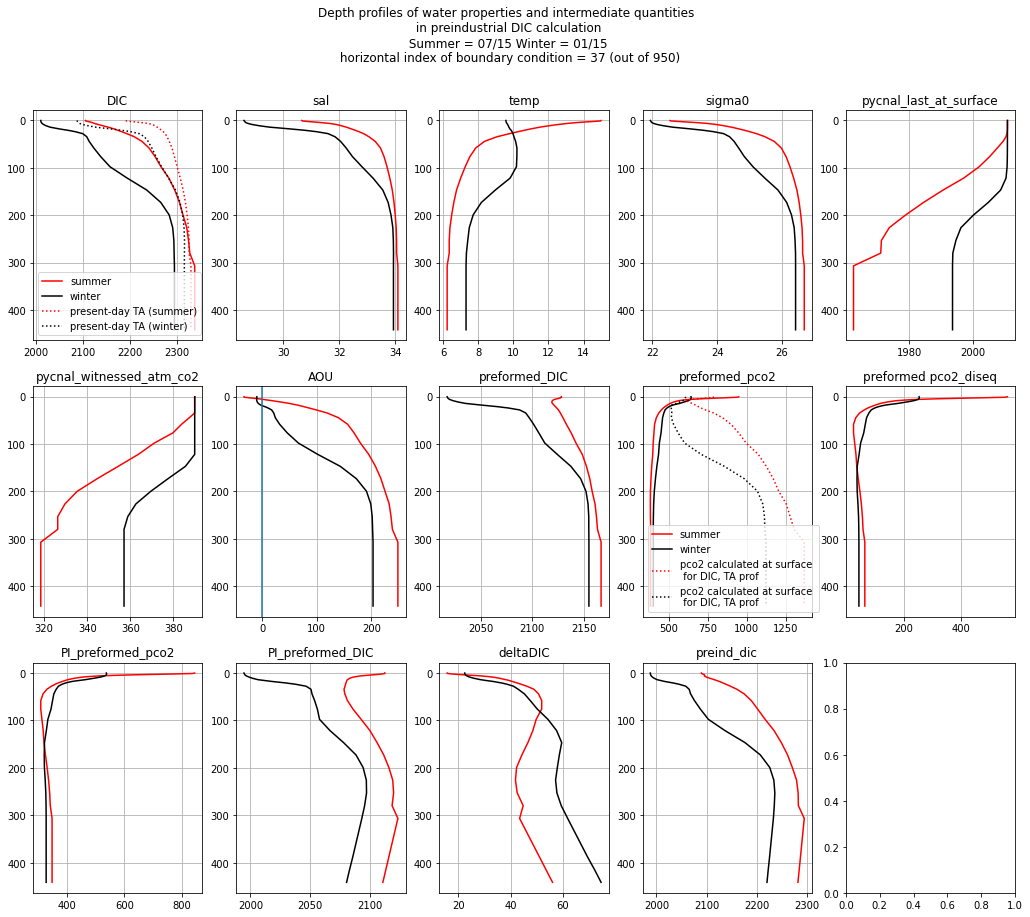

In [14]:
tind = 37
tdir = './test_bcs_04feb21_with_intermediate_calculations/'
datestr = 'y2015m07d15'
ORIG_nc_m07d15_37 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')
datestr = 'y2015m01d15'
ORIG_nc_m01d15_37 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')

w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
zlevels = (w['gdept_1d'][0,:])
print(np.shape(zlevels))

# print(np.shape)


to_plot = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']
tits = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','preformed pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']

fact = 0.8
fig, axs = plt.subplots(3,5, figsize=(22*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,14):
    axs[i].grid()
    axs[i].plot((ORIG_nc_m07d15_37['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'r-', label = 'summer')
    axs[i].plot((ORIG_nc_m01d15_37['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'k-', label = 'winter')
    print(tits[i])
    print('top/bottom of column (summer profile:')
    print(ORIG_nc_m07d15_37['preindustrial_DIC'][to_plot[i]][0,0])
    print(ORIG_nc_m07d15_37['preindustrial_DIC'][to_plot[i]][34,0])
    print()
    axs[i].set_title(tits[i])
    axs[i].invert_yaxis()
    
axs[0].plot((ORIG_nc_m07d15_37['preindustrial_DIC']['TA'][:,0]),zlevels[:],'r:',label = 'present-day TA (summer)')
axs[0].plot((ORIG_nc_m01d15_37['preindustrial_DIC']['TA'][:,0]),zlevels[:],'k:',label = 'present-day TA (winter)')
print('TA (top/bottom summer profile)')
print(ORIG_nc_m07d15_37['preindustrial_DIC']['TA'][0,0])
print(ORIG_nc_m07d15_37['preindustrial_DIC']['TA'][34,0]) 
    
axs[0].legend(loc = 'best')    

axs[8].plot((ORIG_nc_m07d15_37['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'r:',label = 'pco2 calculated at surface \n for DIC, TA prof')
axs[8].plot((ORIG_nc_m01d15_37['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'k:',label = 'pco2 calculated at surface \n for DIC, TA prof')    

print('present-day pco2 - summer profile top bottom')
print(ORIG_nc_m07d15_37['preindustrial_DIC']['present_pco2'][0,0])
print(ORIG_nc_m07d15_37['preindustrial_DIC']['present_pco2'][34,0]) 
axs[8].legend()
axs[6].axvline(x=0)

fig.suptitle('Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/15 Winter = 01/15 \n horizontal index of boundary condition = 37 (out of 950)')


(40,)


Text(0.5, 0.98, 'Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/15 Winter = 01/15 \n horizontal index of boundary condition = 45 (out of 950)')

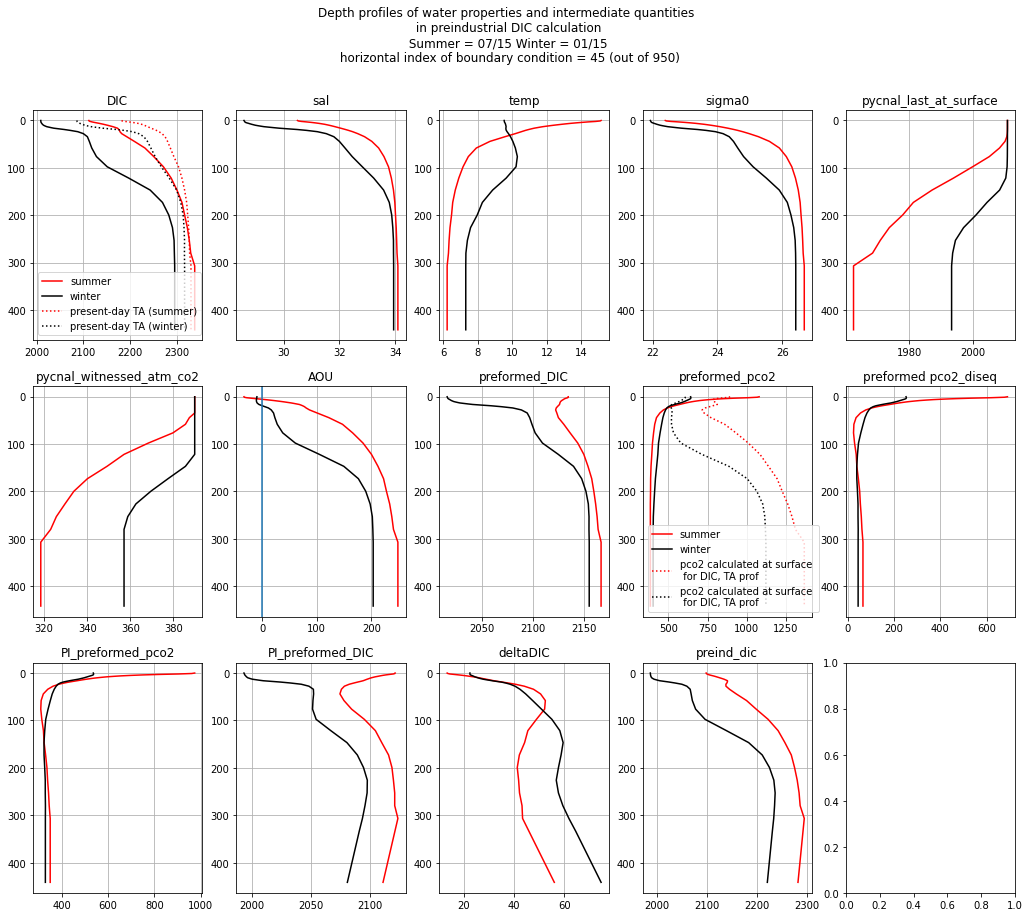

In [7]:
tind = 45
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
zlevels = (w['gdept_1d'][0,:])
print(np.shape(zlevels))
tdir = './test_bcs_04feb21_with_intermediate_calculations/'
datestr = 'y2015m07d15'
ORIG_nc_m07d15_45 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')
datestr = 'y2015m01d15'
ORIG_nc_m01d15_45 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')
# print(np.shape)


to_plot = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']
tits = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','preformed pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']

fact = 0.8
fig, axs = plt.subplots(3,5, figsize=(22*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,14):
    axs[i].grid()
    axs[i].plot((ORIG_nc_m07d15_45['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'r-', label = 'summer')
    axs[i].plot((ORIG_nc_m01d15_45['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'k-', label = 'winter')
    axs[i].set_title(tits[i])
    axs[i].invert_yaxis()
    
axs[0].plot((ORIG_nc_m07d15_45['preindustrial_DIC']['TA'][:,0]),zlevels[:],'r:',label = 'present-day TA (summer)')
axs[0].plot((ORIG_nc_m01d15_45['preindustrial_DIC']['TA'][:,0]),zlevels[:],'k:',label = 'present-day TA (winter)')
 
    
axs[0].legend(loc = 'best')    

axs[8].plot((ORIG_nc_m07d15_45['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'r:',label = 'pco2 calculated at surface \n for DIC, TA prof')
axs[8].plot((ORIG_nc_m01d15_45['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'k:',label = 'pco2 calculated at surface \n for DIC, TA prof')    
axs[8].legend()
axs[6].axvline(x=0)

fig.suptitle('Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/15 Winter = 01/15 \n horizontal index of boundary condition = 45 (out of 950)')


(40,)


Text(0.5, 0.98, 'Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/01 Winter = 01/01 \n horizontal index of boundary condition = 37 (out of 950)')

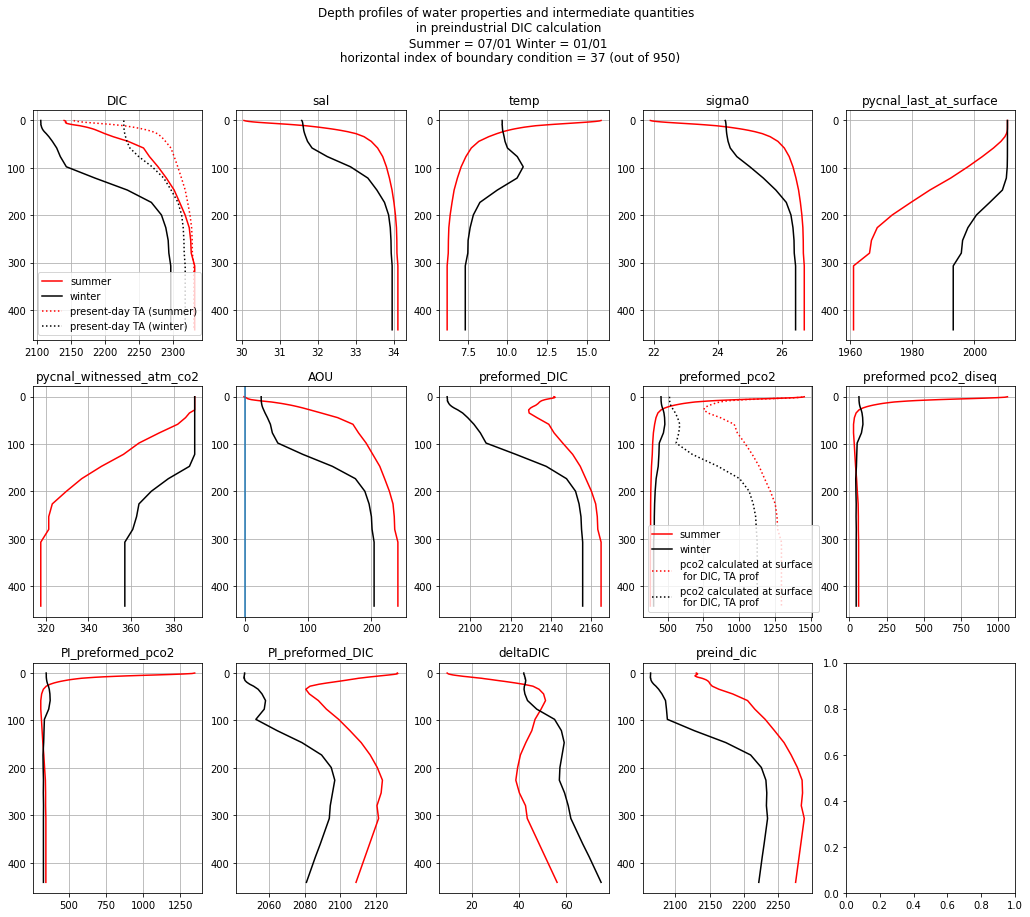

In [8]:
tind = 37
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
zlevels = (w['gdept_1d'][0,:])
print(np.shape(zlevels))
tdir = './test_bcs_04feb21_with_intermediate_calculations/'
datestr = 'y2015m07d01'
ORIG_nc_m07d01_37 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')
datestr = 'y2015m01d01'
ORIG_nc_m01d01_37 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')
# print(np.shape)


to_plot = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']
tits = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','preformed pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']

fact = 0.8
fig, axs = plt.subplots(3,5, figsize=(22*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,14):
    axs[i].grid()
    axs[i].plot((ORIG_nc_m07d01_37['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'r-', label = 'summer')
    axs[i].plot((ORIG_nc_m01d01_37['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'k-', label = 'winter')
    axs[i].set_title(tits[i])
    axs[i].invert_yaxis()
    
axs[0].plot((ORIG_nc_m07d01_37['preindustrial_DIC']['TA'][:,0]),zlevels[:],'r:',label = 'present-day TA (summer)')
axs[0].plot((ORIG_nc_m01d01_37['preindustrial_DIC']['TA'][:,0]),zlevels[:],'k:',label = 'present-day TA (winter)')
 
    
axs[0].legend(loc = 'best')    

axs[8].plot((ORIG_nc_m07d01_37['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'r:',label = 'pco2 calculated at surface \n for DIC, TA prof')
axs[8].plot((ORIG_nc_m01d01_37['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'k:',label = 'pco2 calculated at surface \n for DIC, TA prof')    
axs[8].legend()
axs[6].axvline(x=0)

fig.suptitle('Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/01 Winter = 01/01 \n horizontal index of boundary condition = 37 (out of 950)')


(40,)


Text(0.5, 0.98, 'Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/01 Winter = 01/01 \n horizontal index of boundary condition = 45 (out of 950)')

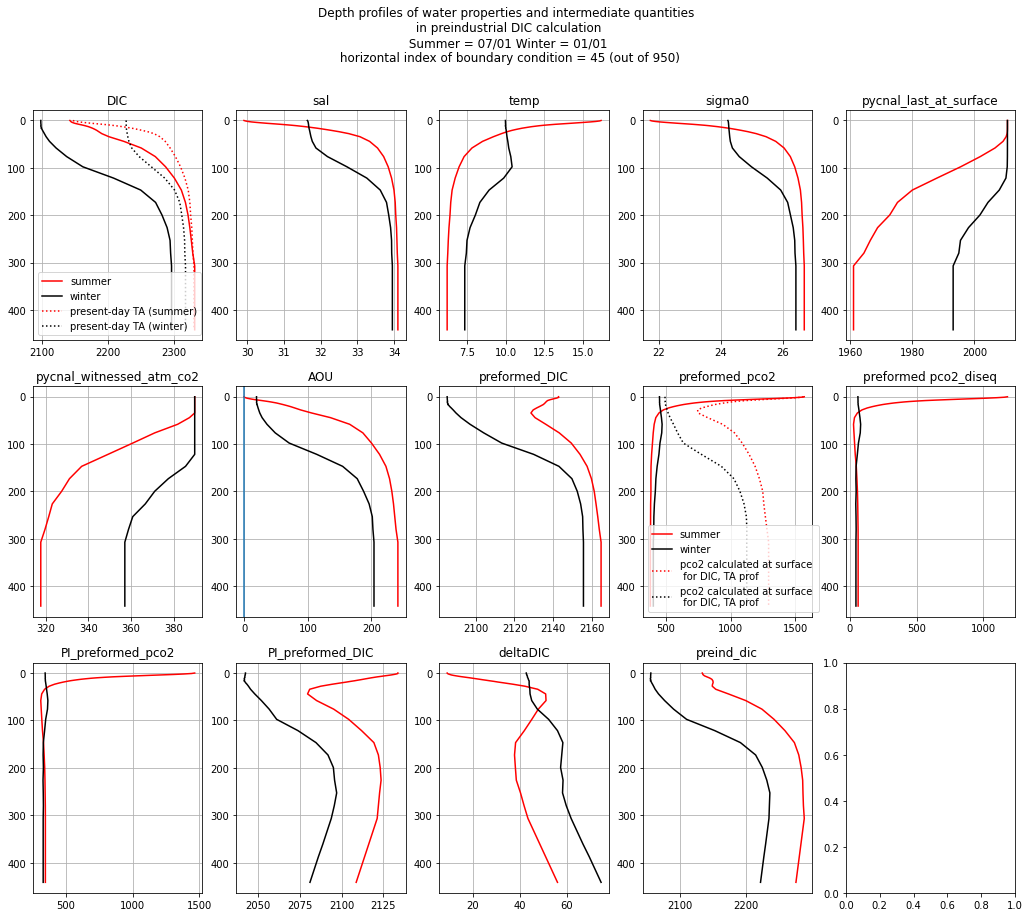

In [9]:
tind = 45
w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
zlevels = (w['gdept_1d'][0,:])
print(np.shape(zlevels))
tdir = './test_bcs_04feb21_with_intermediate_calculations/'
datestr = 'y2015m07d01'
ORIG_nc_m07d01_45 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')
datestr = 'y2015m01d01'
ORIG_nc_m01d01_45 = nc.Dataset(f'{tdir}LO_AOUmethod_ORIG_index_{tind}{datestr}_preind_DIC.nc')
# print(np.shape)


to_plot = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']
tits = ['DIC','sal','temp','sigma0','pycnal_last_at_surface','pycnal_witnessed_atm_co2','AOU','preformed_DIC',\
           'preformed_pco2','preformed pco2_diseq','PI_preformed_pco2','PI_preformed_DIC','deltaDIC','preind_dic']

fact = 0.8
fig, axs = plt.subplots(3,5, figsize=(22*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,14):
    axs[i].grid()
    axs[i].plot((ORIG_nc_m07d01_45['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'r-', label = 'summer')
    axs[i].plot((ORIG_nc_m01d01_45['preindustrial_DIC'][to_plot[i]][:,0]),zlevels[:],'k-', label = 'winter')
    axs[i].set_title(tits[i])
    axs[i].invert_yaxis()
    
axs[0].plot((ORIG_nc_m07d01_45['preindustrial_DIC']['TA'][:,0]),zlevels[:],'r:',label = 'present-day TA (summer)')
axs[0].plot((ORIG_nc_m01d01_45['preindustrial_DIC']['TA'][:,0]),zlevels[:],'k:',label = 'present-day TA (winter)')
 
    
axs[0].legend(loc = 'best')    

axs[8].plot((ORIG_nc_m07d01_45['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'r:',label = 'pco2 calculated at surface \n for DIC, TA prof')
axs[8].plot((ORIG_nc_m01d01_45['preindustrial_DIC']['present_pco2'][:,0]),\
            zlevels[:],'k:',label = 'pco2 calculated at surface \n for DIC, TA prof')    
axs[8].legend()
axs[6].axvline(x=0)

fig.suptitle('Depth profiles of water properties and intermediate quantities \n in preindustrial DIC calculation \n Summer = 07/01 Winter = 01/01 \n horizontal index of boundary condition = 45 (out of 950)')


In [13]:
print(2105+33*(117/170))

2127.711764705882


In [15]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    import sys
    sys.path.append('/data/tjarniko/mocsy')
    import mocsy
    import numpy as np
    import gsw
    
    size_box = np.shape(tdic)
    print(size_box)

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH
    OmAr = OmegaA
    pco2r = pco2
    
    return pHr, OmAr, pco2r

In [18]:
pHr, OmAr, pco2r = oned_moxy(30.666666, 14.995259, 2128.4585, 2191.5574, 1, 0)
print(pco2r)

()
[949.51881416]
